In [29]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [30]:
data = data.fillna(method="ffill")

In [31]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [34]:
n_words = len(words)
# n_words

In [35]:
tags = list(set(data["Tag"].values))

In [36]:
n_tags = len(tags); n_tags

17

In [37]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [38]:
getter = SentenceGetter(data)

In [39]:
sent = getter.get_next()

In [40]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [41]:
sentences = getter.sentences

In [42]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

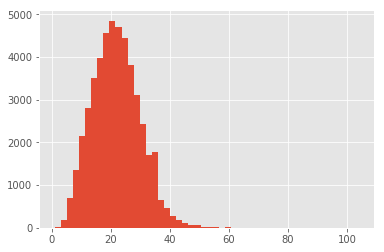

In [43]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [44]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [45]:
word2idx["Obama"]

34546

In [46]:
tag2idx["B-geo"]

13

In [47]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.
/home/textmining/anaconda3/envs/deep_toxic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/textmining/anaconda3/envs/deep_toxic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/textmining/anaconda3/envs/deep_toxic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [48]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [49]:
X[1]

array([  823,  4118, 28282, 32250,  1234, 15555,  7983,  1731, 15555,
       29388, 21348, 27274, 21502, 23072, 17037, 28650,  7433, 16376,
       12254, 33711, 13594,  7745,   633, 27492,  1738, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [50]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [51]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [52]:
from keras.utils import to_categorical

In [53]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [56]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [57]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [58]:
model = Model(input, out)

In [59]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 12s 314us/step - loss: 0.1401 - acc: 0.9593 - val_loss: 0.0994 - val_acc: 0.9724
Epoch 2/5
38846/38846 [==============================] - 12s 310us/step - loss: 0.0798 - acc: 0.9776 - val_loss: 0.0641 - val_acc: 0.9816
Epoch 3/5
38846/38846 [==============================] - 12s 310us/step - loss: 0.0567 - acc: 0.9836 - val_loss: 0.0530 - val_acc: 0.9843
Epoch 4/5
38846/38846 [==============================] - 12s 311us/step - loss: 0.0475 - acc: 0.9861 - val_loss: 0.0491 - val_acc: 0.9853
Epoch 5/5
38846/38846 [==============================] - 12s 311us/step - loss: 0.0424 - acc: 0.9874 - val_loss: 0.0472 - val_acc: 0.9858


In [63]:
i = 2310
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
Goldman        : B-per
Sachs          : I-per
is             : O
eager          : O
to             : O
pay            : O
all            : O
of             : O
the            : O
$              : O
10             : O
billion        : O
it             : O
received       : O
from           : O
the            : O
federal        : O
Troubled       : B-org
Asset          : I-org
Relief         : I-org
Program        : I-org
,              : O
as             : O
soon           : O
as             : O
the            : O
government     : O
approves       : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         

In [7]:
import sklearn.model_selection 

In [8]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [9]:
data = data.fillna(method="ffill")

In [10]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [11]:
words = list(set(data["Word"].values))

In [12]:
n_words = len(words); n_words

35178

In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [14]:
getter = SentenceGetter(data)

In [15]:
sent = getter.get_next()

In [16]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [17]:
sentences = getter.sentences

In [18]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [19]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [20]:
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

In [22]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [23]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-art       0.37      0.11      0.17       402
       B-eve       0.52      0.35      0.42       308
       B-geo       0.85      0.90      0.88     37644
       B-gpe       0.97      0.94      0.95     15870
       B-nat       0.66      0.37      0.47       201
       B-org       0.78      0.72      0.75     20143
       B-per       0.84      0.81      0.82     16990
       B-tim       0.93      0.88      0.90     20333
       I-art       0.11      0.03      0.04       297
       I-eve       0.34      0.21      0.26       253
       I-geo       0.82      0.79      0.80      7414
       I-gpe       0.92      0.55      0.69       198
       I-nat       0.61      0.27      0.38        51
       I-org       0.81      0.79      0.80     16784
       I-per       0.84      0.89      0.87     17251
       I-tim       0.83      0.76      0.80      6528
           O       0.99      0.99      0.99    887908

   micro avg       0.97   

In [24]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [27]:
import eli5

In [28]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.29,0.879,0.0,1.575,0.0,2.092,0.0,1.387,0.0,1.605,0.0,2.497,0.0,4.17,0.0,2.986,0.0
B-art,-0.014,0.0,8.442,0.0,0.0,-0.398,0.0,0.0,0.0,0.0,0.0,0.516,0.0,-0.844,0.0,0.336,0.0
I-art,-0.651,0.0,8.04,0.0,0.0,-0.702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.0,-0.684,0.0
B-eve,-0.753,0.0,0.0,0.0,7.956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.572,0.0
I-eve,-0.324,0.0,0.0,0.0,7.341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.621,0.0
B-geo,0.677,0.752,0.0,0.545,0.0,0.0,8.752,0.579,0.0,0.0,0.0,1.155,0.0,1.143,0.0,2.344,0.0
I-geo,-0.469,0.822,0.0,0.0,0.0,0.0,7.424,-1.366,0.0,0.0,0.0,-0.074,0.0,1.331,0.0,1.033,0.0
B-gpe,0.679,-1.609,0.0,-0.32,0.0,0.681,0.0,0.0,7.485,0.0,0.0,2.05,0.0,1.459,0.0,0.767,0.0
I-gpe,-0.298,0.0,0.0,0.0,0.0,-1.087,0.0,0.0,6.337,0.0,0.0,0.0,0.0,0.148,0.0,0.0,0.0
B-nat,-1.108,0.0,0.0,0.0,0.0,0.625,0.0,0.0,0.0,0.0,7.067,0.0,0.0,-0.305,0.0,-0.413,0.0


In [ ]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [ ]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [ ]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

In [ ]:
crf.fit(X, y)

In [ ]:
eli5.show_weights(crf, top=30)